In [1]:
import numpy as np
import pandas as pd

In [ ]:
!pip install fastai
from fastai.tabular.all import *

In [3]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [4]:
cd ../content/gdrive

/content/gdrive


In [5]:
cd MyDrive/dmt_project/

/content/gdrive/MyDrive/dmt_project


In [6]:
df = pd.read_csv("data.csv")

In [7]:
# Randomise dataset
df = df.sample(frac=1).reset_index(drop=True)
df.head()

id diagnosis  radius_mean  texture_mean  perimeter_mean  area_mean  \
0    8610862         M        20.18         23.97          143.70     1245.0   
1  911296201         M        17.08         27.15          111.20      930.9   
2    9113156         B        14.40         26.99           92.25      646.1   
3     911384         B        14.92         14.93           96.45      686.9   
4     892399         B        10.51         23.09           66.85      334.2   

   smoothness_mean  compactness_mean  concavity_mean  concave points_mean  \
0          0.12860           0.34540         0.37540              0.16040   
1          0.09898           0.11100         0.10070              0.06431   
2          0.06995           0.05223         0.03476              0.01737   
3          0.08098           0.08549         0.05539              0.03221   
4          0.10150           0.06797         0.02495              0.01875   

   ...  texture_worst  perimeter_worst  area_worst  smoothness_worst  \
0  ...          31.72            170.3      1623.0            0.1639   
1  ...          34.49            152.1      1648.0            0.1600   
2  ...          31.98            100.4       734.6            0.1017   
3  ...          18.22            112.0       906.6            0.1065   
4  ...          24.22             70.1       362.7            0.1143   

   compactness_worst  concavity_worst  concave points_worst  symmetry_worst  \
0            0.61640          0.76810               0.25080          0.5440   
1            0.24440          0.26390               0.15550          0.3010   
2            0.14600          0.14720               0.05563          0.2345   
3            0.27910          0.31510               0.11470          0.2688   
4            0.08614          0.04158               0.03125          0.2227   

   fractal_dimension_worst  Unnamed: 32  
0                  0.09964          NaN  
1                  0.09060          NaN  
2                  0.06464          NaN  
3                  0.08273          NaN  
4                  0.06777          NaN  

[5 rows x 33 columns]

In [8]:
part = np.random.rand(len(df)) < 0.9
df_train = df[part]
df_test = df[~part]

print('test_set', len(df_test))
print('training_set', len(df_train))

test_set 64
training_set 505


In [30]:
splits = IndexSplitter(list(range(int(len(df_train)*.8),len(df_train))))(range_of(df_train))

In [34]:
cls='diagnosis'
procs = [Categorify, FillMissing, Normalize]
to = TabularPandas(df_train, procs, [], list(df_train.columns)[2:-1], y_names=cls, splits=splits)
dls = to.dataloaders(bs=64)
dls.show_batch()

SuggestedLRs(valley=0.002511886414140463)

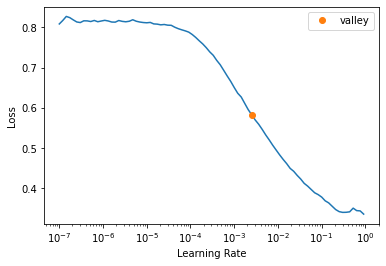

In [36]:
learn = tabular_learner(dls, layers=[200,100], metrics=accuracy)
learn.lr_find()

In [37]:
learn.fit(10,lr=10e-3)

In [38]:
from sklearn.model_selection import StratifiedKFold

In [39]:
skf = StratifiedKFold(n_splits=10, shuffle=True, random_state=1)

In [40]:
test_dl = dls.test_dl(df_test, with_labels=True)
preds, target = learn.get_preds(dl=test_dl)
print(accuracy(preds,target).item()*100)

92.1875


In [51]:
interp=ClassificationInterpretation.from_learner(learn)

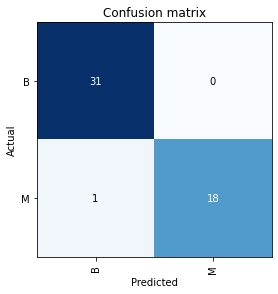

In [52]:
interp.plot_confusion_matrix()

In [16]:
interp.print_classification_report()

              precision    recall  f1-score   support

           B       0.97      1.00      0.98        63
           M       1.00      0.95      0.97        38

    accuracy                           0.98       101
   macro avg       0.98      0.97      0.98       101
weighted avg       0.98      0.98      0.98       101



In [47]:
val_pct = []
test_pct = []
for train_index, val_index in skf.split(df_train.index, df_train[cls]):
  splits = (L(list(train_index)), L(list(val_index)))
  to = TabularPandas(df_train, procs, [], list(df_train.columns)[2:-1], y_names=cls, splits=splits)
  dls = to.dataloaders(bs=64)
  learn = tabular_learner(dls, layers=[200,100], metrics=accuracy)
  learn.fit(3, 1e-2)
  
  test_dl = dls.test_dl(df_test, with_labels=True)
  
  with learn.no_bar():
    val_pct.append(learn.validate()[-1])
    test_pct.append(learn.get_preds(dl=test_dl))

In [49]:
for i, (pred, truth) in enumerate(test_pct):
    print(f'Fold {i+1}: {accuracy(pred, truth)}')

Fold 1: 0.921875
Fold 2: 0.9375
Fold 3: 0.9375
Fold 4: 0.953125
Fold 5: 0.9375
Fold 6: 0.953125
Fold 7: 0.953125
Fold 8: 0.9375
Fold 9: 0.921875
Fold 10: 0.96875


In [50]:
sum_preds = []
for i, (pred, truth) in enumerate(test_pct):
    sum_preds.append(pred.numpy())
avg_preds = np.sum(sum_preds, axis=0) / 5
print(f'Average Accuracy: {accuracy(tensor(avg_preds), test_pct[0][1])}')

Average Accuracy: 0.953125
